In [11]:
import numpy as np
import pandas as pd


In [22]:
df1 = pd.read_csv("UNSW_filtered_data.csv")

df1.shape

(2784, 44)

In [49]:
df2= pd.read_csv("UNSW_augmented_filtered_data.csv")
df2.shape

(257673, 44)

In [55]:
df=pd.concat([df1,df2],axis=0)

In [56]:
df.shape

(260457, 44)

In [57]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,3.363884e-03,0.856061,0.416667,0.4,0.000845,0.000545,0.000089,0.000018,0.000074,0.996078,...,0.0,0.0,0.0,0.0,0.033333,0.000000,0.016393,0.0,9,1.0
1,7.058351e-02,0.856061,0.416667,0.4,0.004227,0.021419,0.000160,0.021044,0.000066,0.996078,...,0.0,0.0,0.0,0.0,0.033333,0.000000,0.000000,0.0,9,1.0
2,3.280367e-03,0.856061,0.416667,0.4,0.000845,0.000545,0.000070,0.000018,0.000076,0.996078,...,0.0,0.0,0.0,0.0,0.033333,0.000000,0.000000,0.0,9,1.0
3,2.101572e-02,0.856061,0.416667,0.4,0.000845,0.000545,0.000088,0.000018,0.000012,0.996078,...,0.0,0.0,0.0,0.0,0.033333,0.000000,0.000000,0.0,9,1.0
4,8.333335e-08,0.901515,0.000000,0.5,0.000094,0.000000,0.000005,0.000000,0.200000,0.996078,...,0.0,0.0,0.0,0.0,0.000000,0.305085,0.000000,0.0,9,1.0


In [59]:
selected_features=['dur','proto','service','state','sbytes','dbytes','dload','sloss','sinpkt',
                   'sjit','swin','stcpb','dtcpb','dwin','synack','ackdat','dmean','trans_depth',
                   'ct_state_ttl','ct_dst_src_ltm','ct_ftp_cmd','ct_src_ltm']

In [60]:
df_selected=df[selected_features]
df_selected.shape

(260457, 22)

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [62]:

X = df_selected.values
y = df['attack_cat'].values

In [63]:
X.shape

(260457, 22)

In [64]:
# One-hot encode the target for multiclass classification
y_encoded = pd.get_dummies(y).values


In [65]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [66]:
X_test.shape

(52092, 22)

In [67]:
# Reshape X for CNN and LSTM input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [68]:
# Define CNN Model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, output)
    return model


In [69]:
# Define LSTM Model
def create_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, output)
    return model


In [70]:
# Define FNN Model
def create_fnn_model(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, output)
    return model


In [71]:
# Define attention mechanism
def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights


In [72]:
# Number of classes in the dataset
num_classes = y_train.shape[1]

# Create individual models
input_shape_cnn = (X_train_cnn.shape[1], 1)
input_shape_lstm = (X_train_cnn.shape[1], 1)
input_shape_fnn = X_train.shape[1]


In [73]:
cnn_model = create_cnn_model(input_shape_cnn, num_classes)
lstm_model = create_lstm_model(input_shape_lstm, num_classes)
fnn_model = create_fnn_model(input_shape_fnn, num_classes)


In [74]:
# Compile the individual models
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [75]:
# Fit the individual models
cnn_history=cnn_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [76]:
lstm_history=lstm_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [77]:
fnn_history=fnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Get validation accuracy for dynamic weighting
cnn_val_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_val_accuracy = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
fnn_val_accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)[1]

In [80]:
# Calculate dynamic weights based on validation accuracy
total_accuracy = cnn_val_accuracy + lstm_val_accuracy + fnn_val_accuracy
weights = {
    'cnn': cnn_val_accuracy / total_accuracy,
    'lstm': lstm_val_accuracy / total_accuracy,
    'fnn': fnn_val_accuracy / total_accuracy
}

In [81]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout, Multiply, Lambda
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
# Weighted outputs using Lambda layers
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)

In [83]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')


In [84]:
# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

In [85]:
# Final output layer
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)


In [86]:
# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)


In [87]:
# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [88]:
# Train the ensemble model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = ensemble_model.fit(
    [X_train_cnn, X_train_cnn, X_train],
    y_train,
    validation_data=([X_test_cnn, X_test_cnn, X_test], y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],verbose=0
)

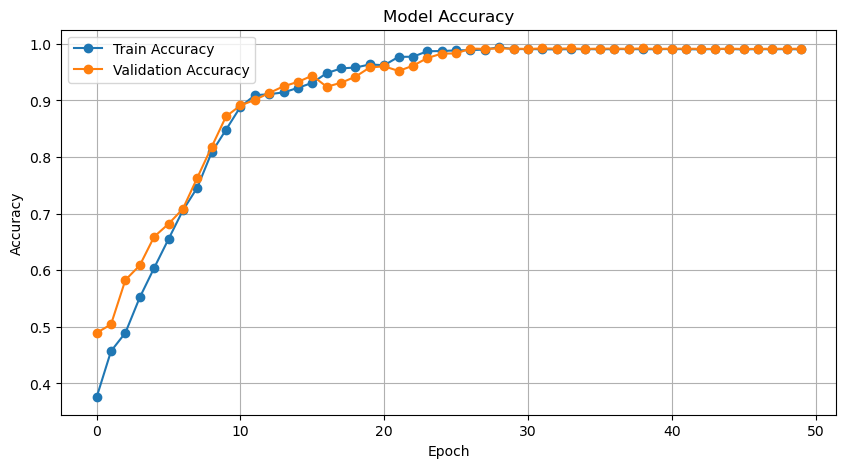

In [182]:
# Evaluate the model and visualize results
# Accuracy and loss plots
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("UNSW_Accuracy_multiclass.png")
plt.show()

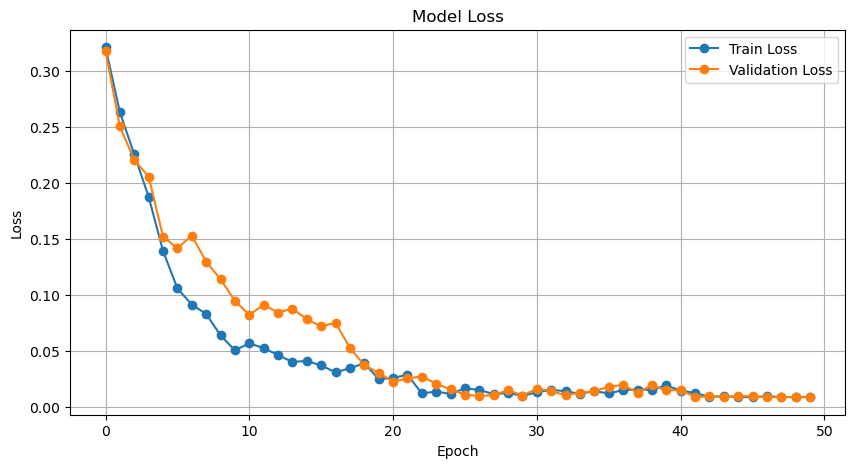

In [183]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("UNSW_loss_multiclass.png")
plt.show()

In [101]:
# Confusion matrix
y_pred = ensemble_model.predict([X_test_cnn, X_test_cnn, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)



1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step


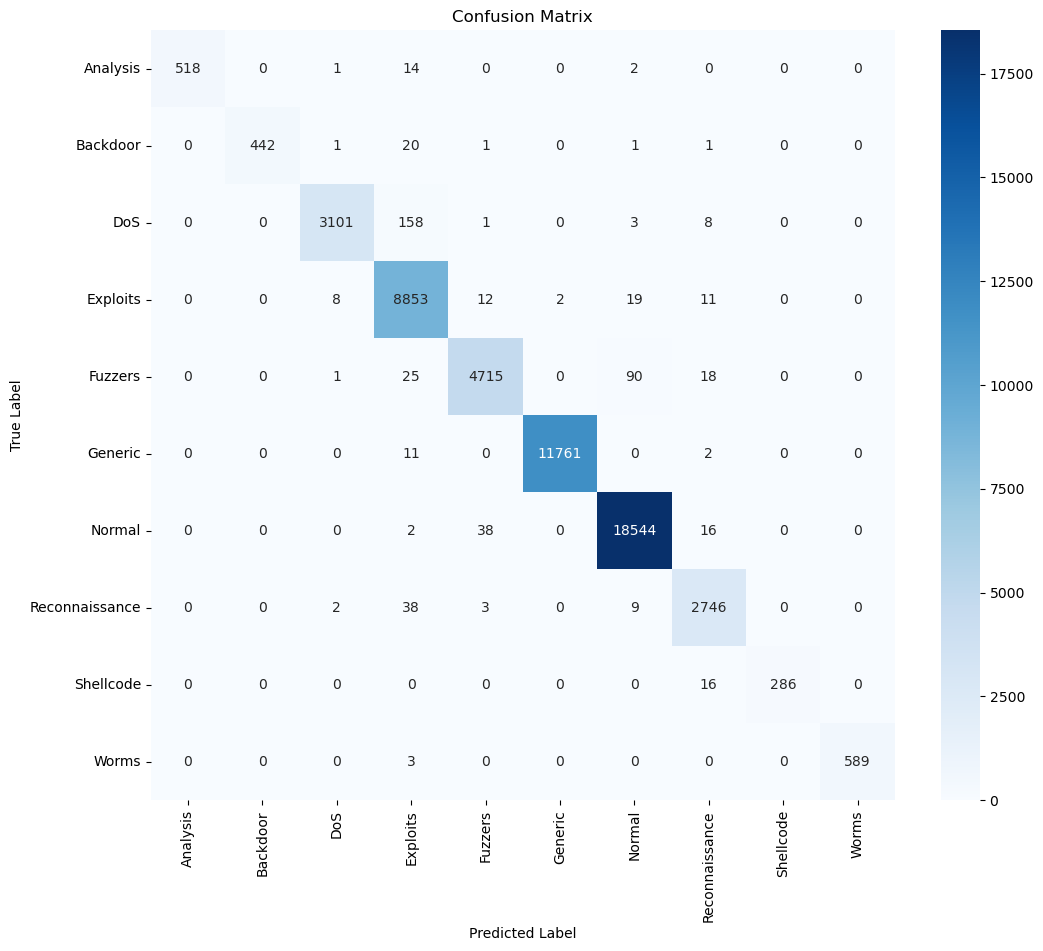

In [163]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('UNSW_confusion_matrix_multiclass.png')
plt.show()

In [164]:
# Classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print(report)

                precision    recall  f1-score   support

      Analysis       1.00      0.97      0.98       535
      Backdoor       1.00      0.95      0.97       466
           DoS       1.00      0.95      0.97      3271
      Exploits       0.97      0.99      0.98      8905
       Fuzzers       0.99      0.97      0.98      4849
       Generic       1.00      1.00      1.00     11774
        Normal       0.99      1.00      1.00     18600
Reconnaissance       0.97      0.98      0.98      2798
     Shellcode       1.00      0.95      0.97       302
         Worms       1.00      0.99      1.00       592

      accuracy                           0.99     52092
     macro avg       0.99      0.98      0.98     52092
  weighted avg       0.99      0.99      0.99     52092



In [224]:

# Extract attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

avg_attention_weights = np.mean(attention_weights_test, axis=0)

attention_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(avg_attention_weights.shape[0])],
    'Attention Weight': avg_attention_weights
})



1628/1628 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step


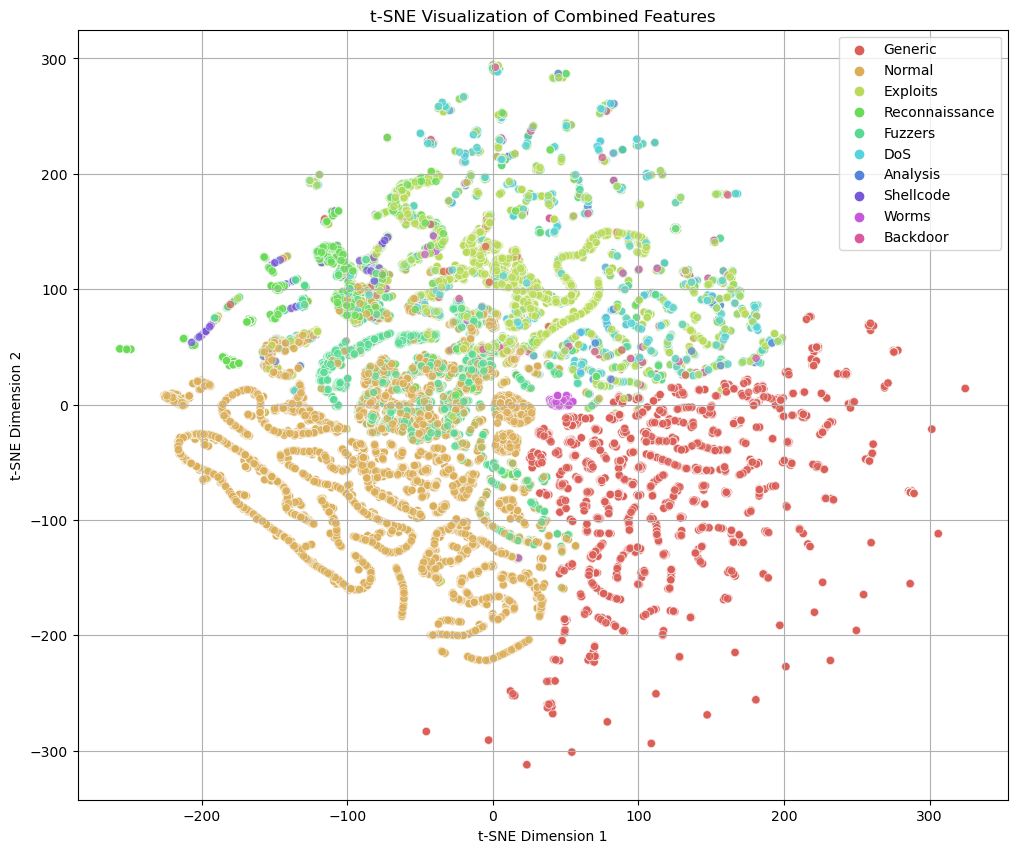

In [109]:
from sklearn.manifold import TSNE

# Extract combined features from the ensemble model before the attention mechanism
feature_extractor = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('combined_features').output)
combined_features_test = feature_extractor.predict([X_test_cnn, X_test_cnn, X_test])

# Perform t-SNE to reduce the combined features to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(combined_features_test)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Attack Category': label_encoder.inverse_transform(y_true_classes)
})

# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Attack Category',
    palette=sns.color_palette('hls', len(label_encoder.classes_)),
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


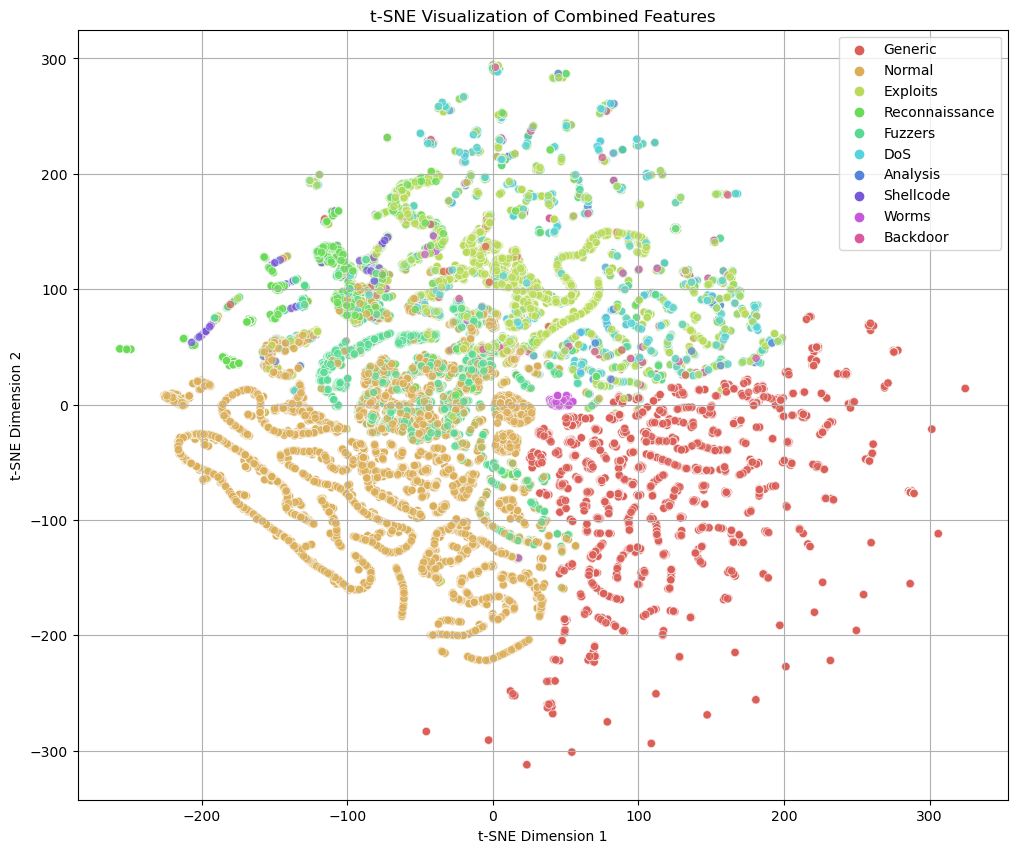

In [155]:
# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Attack Category',
    palette=sns.color_palette('hls', len(label_encoder.classes_)),
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('UNSW_multiclass_t-SNE.png')
plt.show()


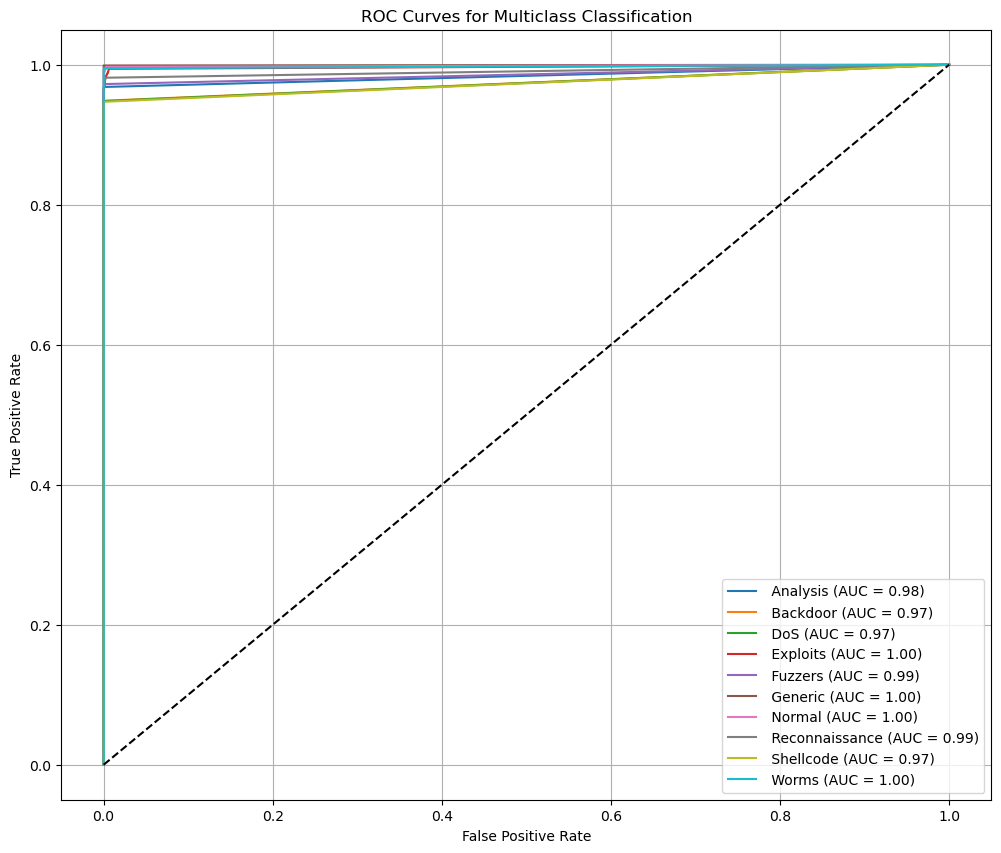

In [168]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Binarize the true labels
y_test_binarized = label_binarize(y_true_classes, classes=range(len(label_encoder.classes_)))

# Compute ROC AUC and Precision-Recall for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred[:, i])

# Plotting ROC Curves
plt.figure(figsize=(12, 10))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f' {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for Multiclass Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("UNSW_ROC_Multiclass.png")
plt.show()



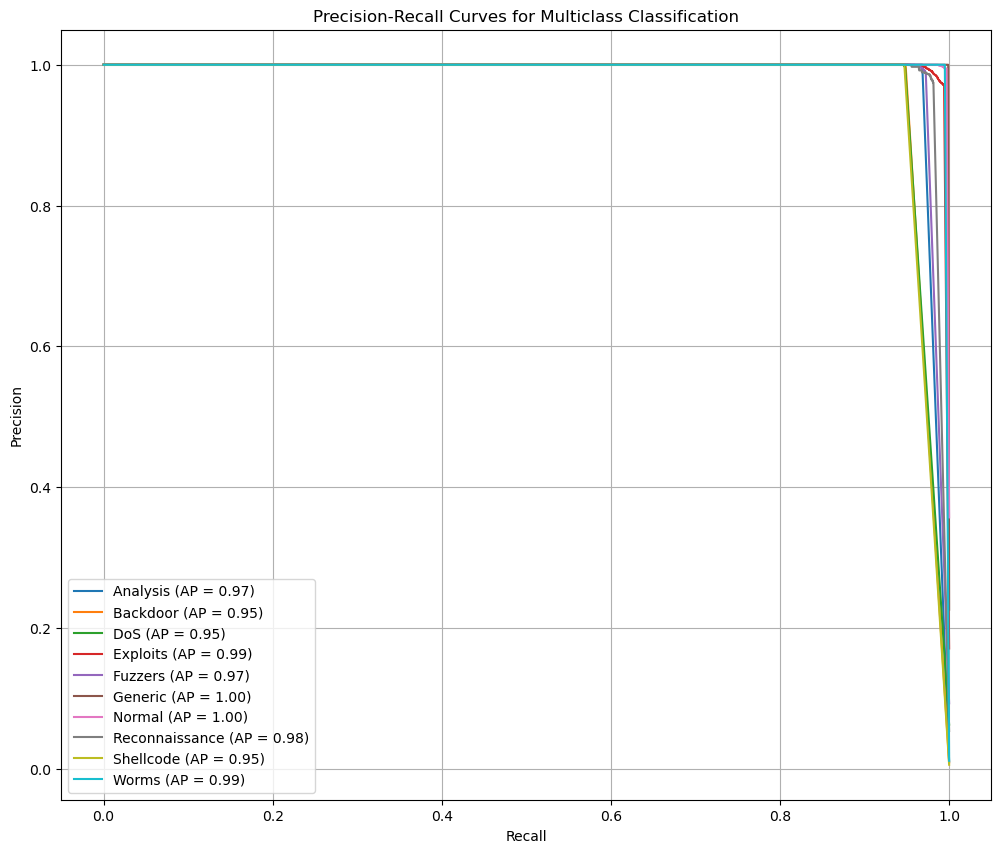

In [170]:
# Plotting Precision-Recall Curves
plt.figure(figsize=(12, 10))
for i in range(len(label_encoder.classes_)):
    plt.plot(recall[i], precision[i], label=f'{label_encoder.classes_[i]} (AP = {average_precision[i]:0.2f})')
plt.title('Precision-Recall Curves for Multiclass Classification')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig("UNSW_precision_recall_Multiclass.png")
plt.show()

In [196]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Reduce the combined features to 22
combined = Dense(22, activation='relu')(combined)

In [197]:
# Apply attention mechanism on reduced combined output
attention_output, attention_weights = attention_mechanism(combined)

In [198]:
# Final output layer
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [199]:
# Assuming you have combined features from CNN, LSTM, and FNN
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Reduce the combined features to 22
combined = Dense(22, activation='relu')(combined)

# Apply attention mechanism on reduced combined output
attention_output, attention_weights = attention_mechanism(combined)

# Final output layer
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [201]:
# Extract attention weights for the test set
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

# Verify the shape of attention weights
print(f"Attention weights shape: {attention_weights_test.shape}")

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Attention weights shape: (52092, 22)


In [208]:
feature_names = df_selected.columns.tolist()

In [209]:
attention_df = pd.DataFrame({
    'Feature': feature_names,
    'Attention Weight': avg_attention_weights
})

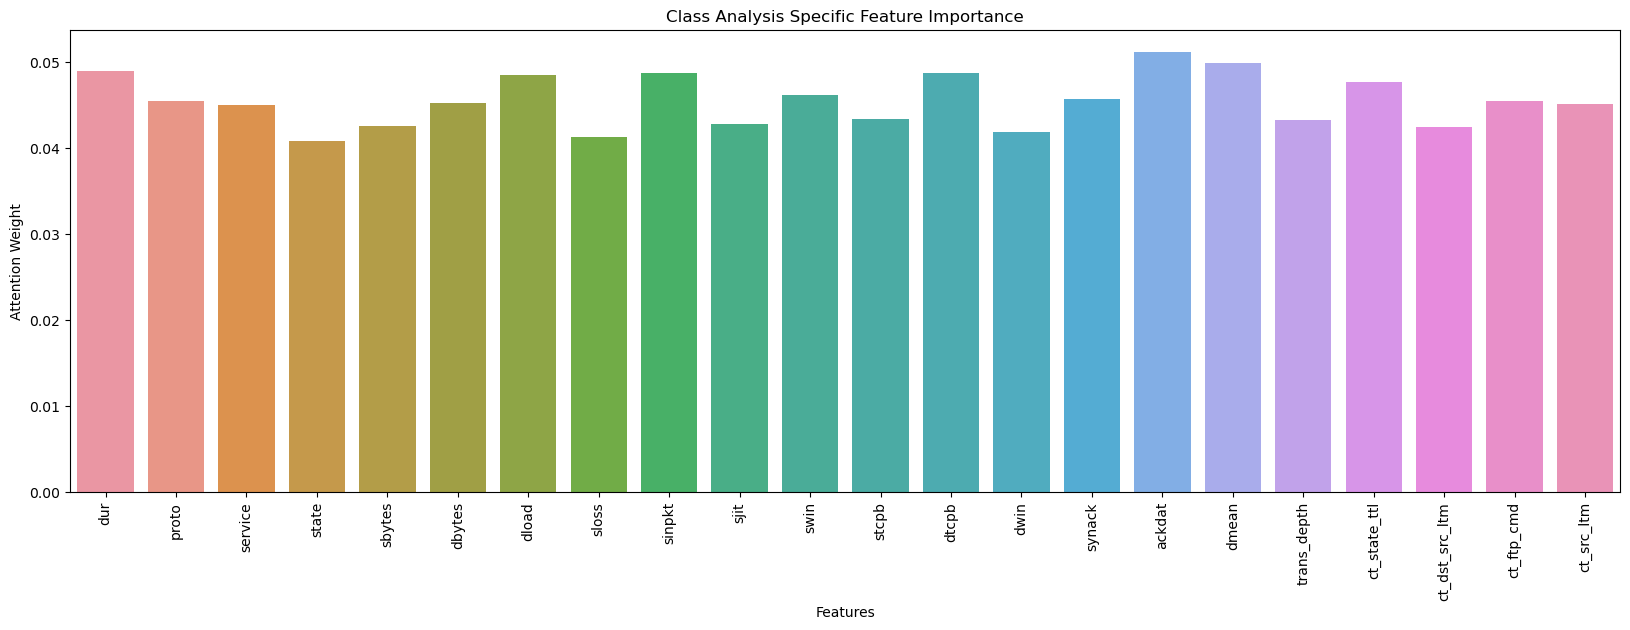

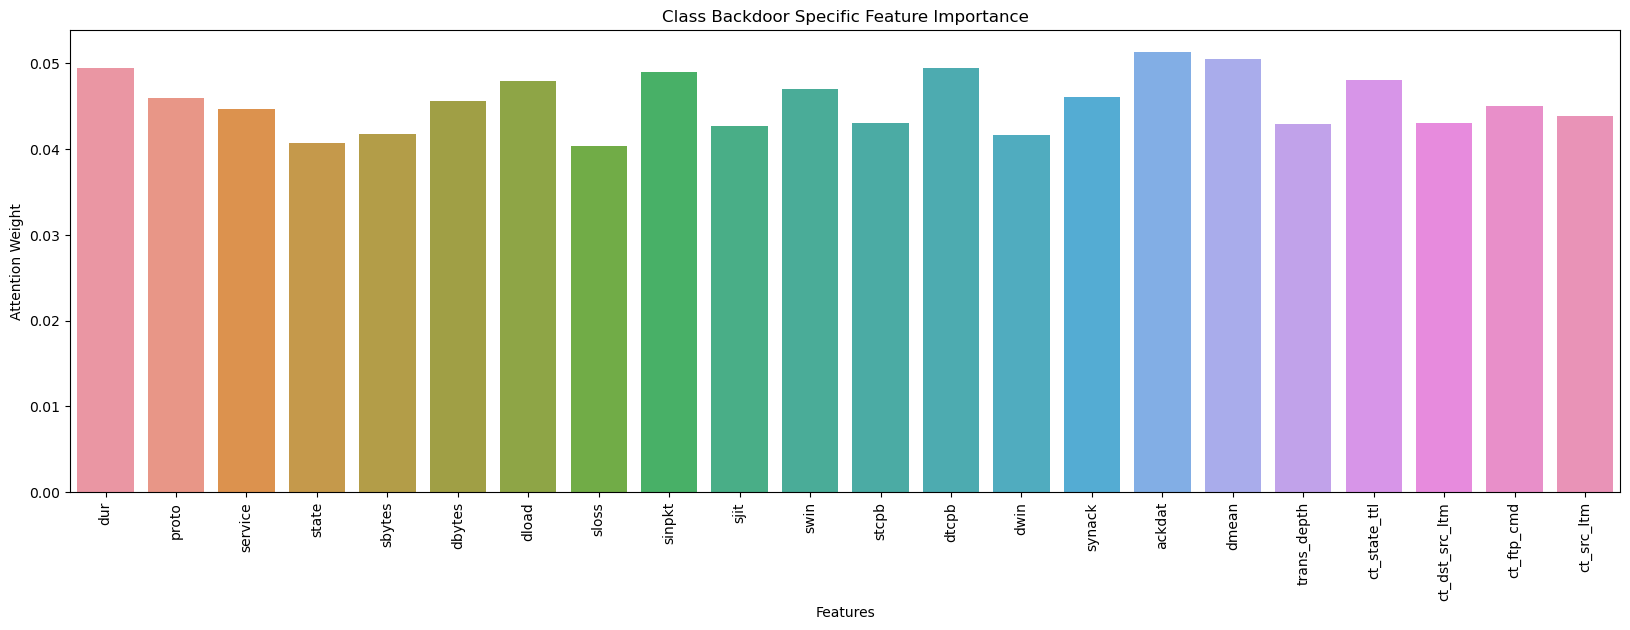

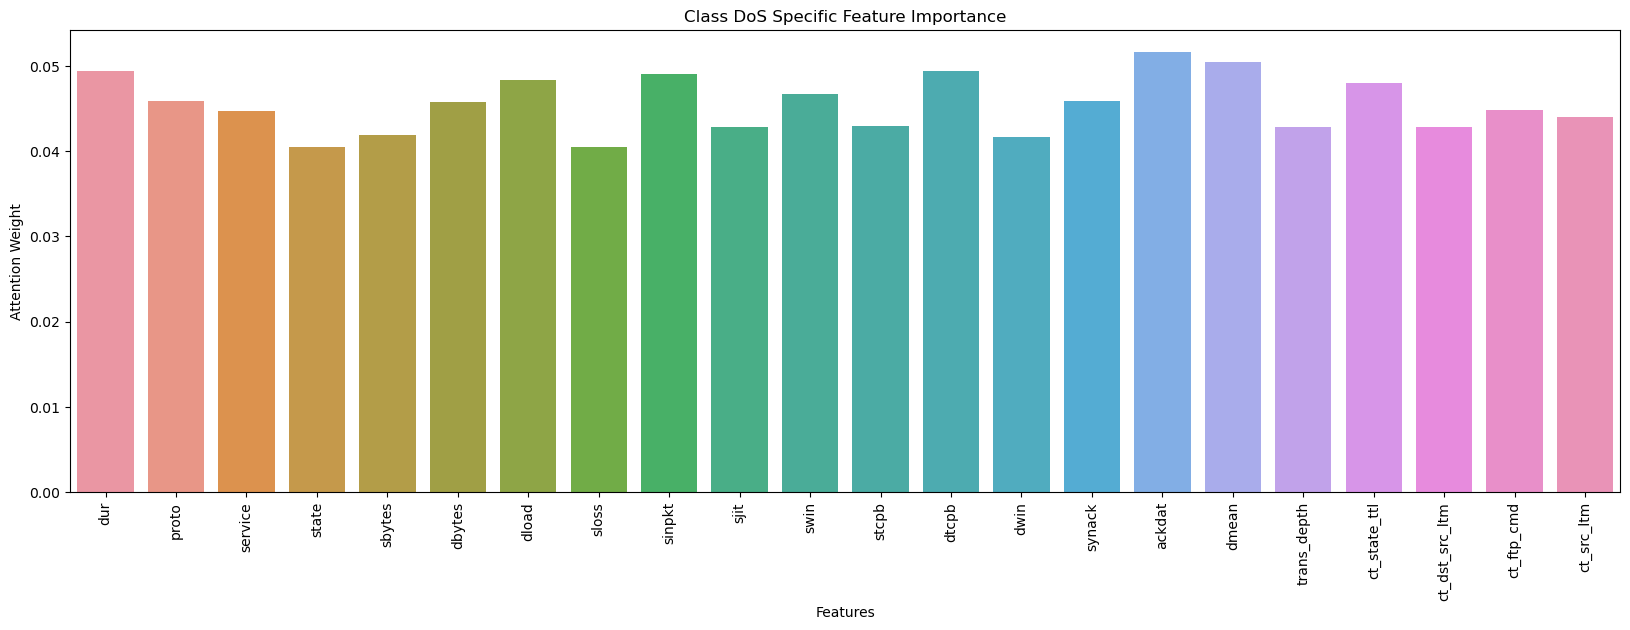

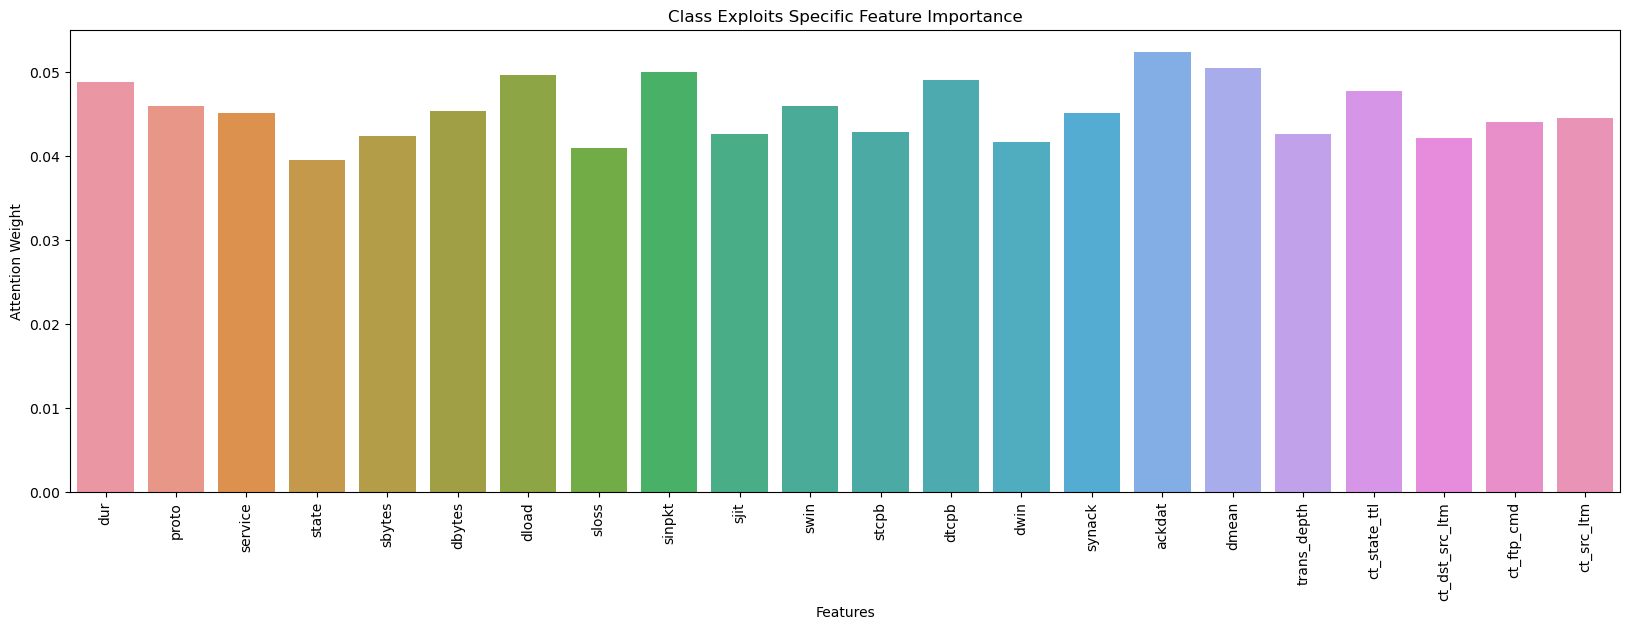

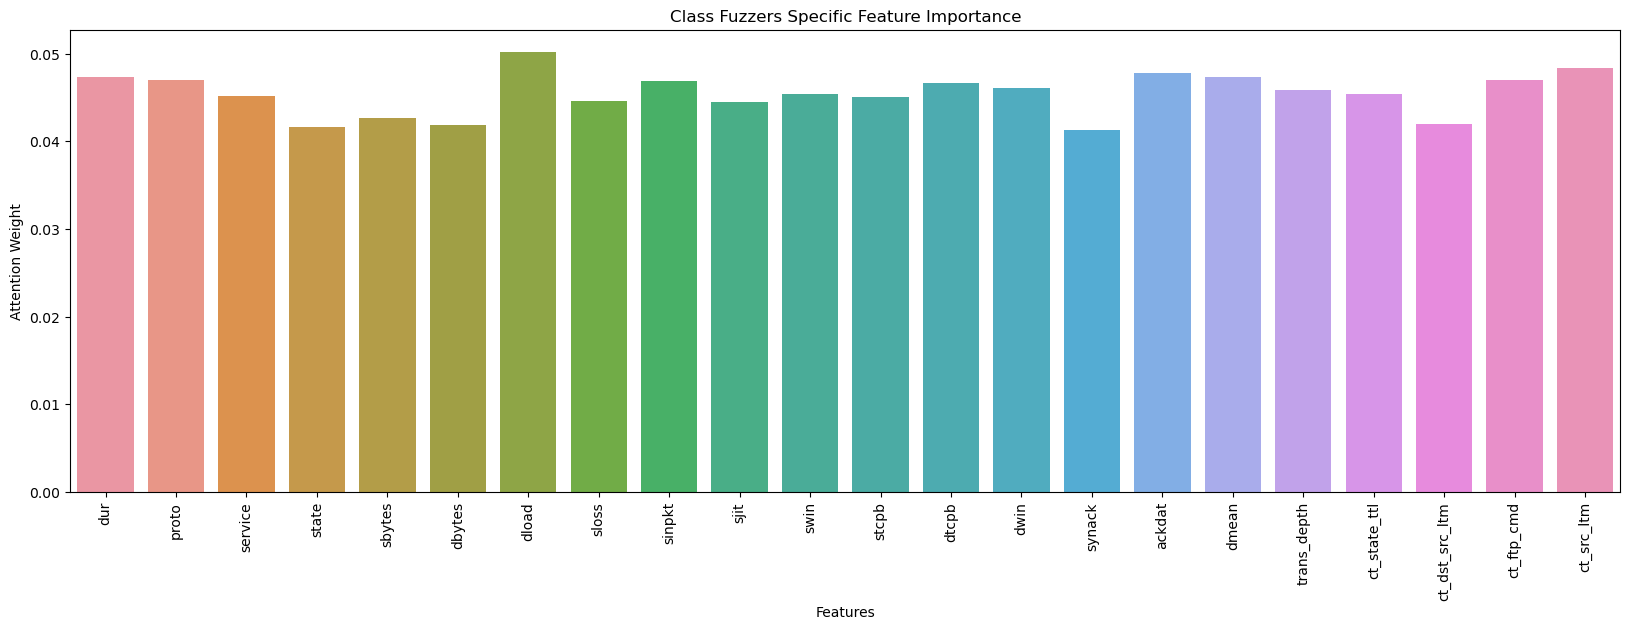

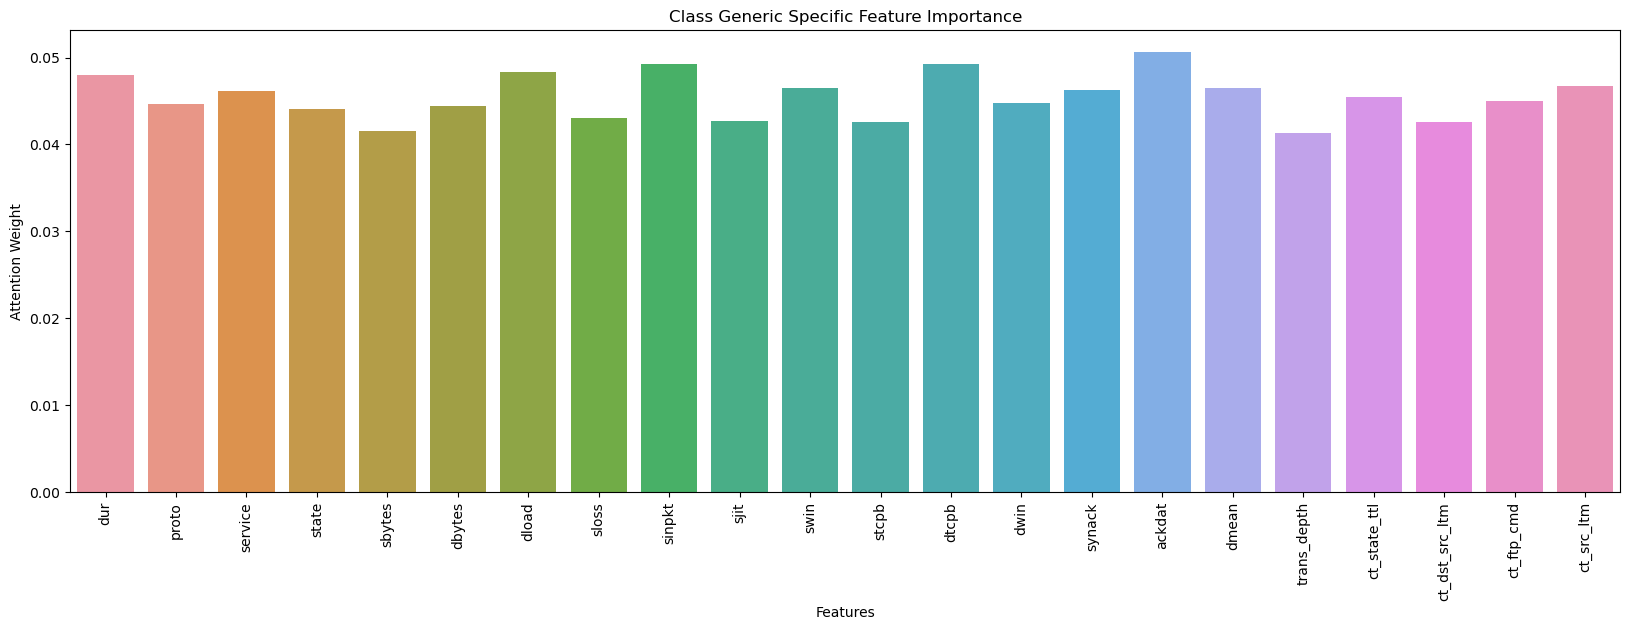

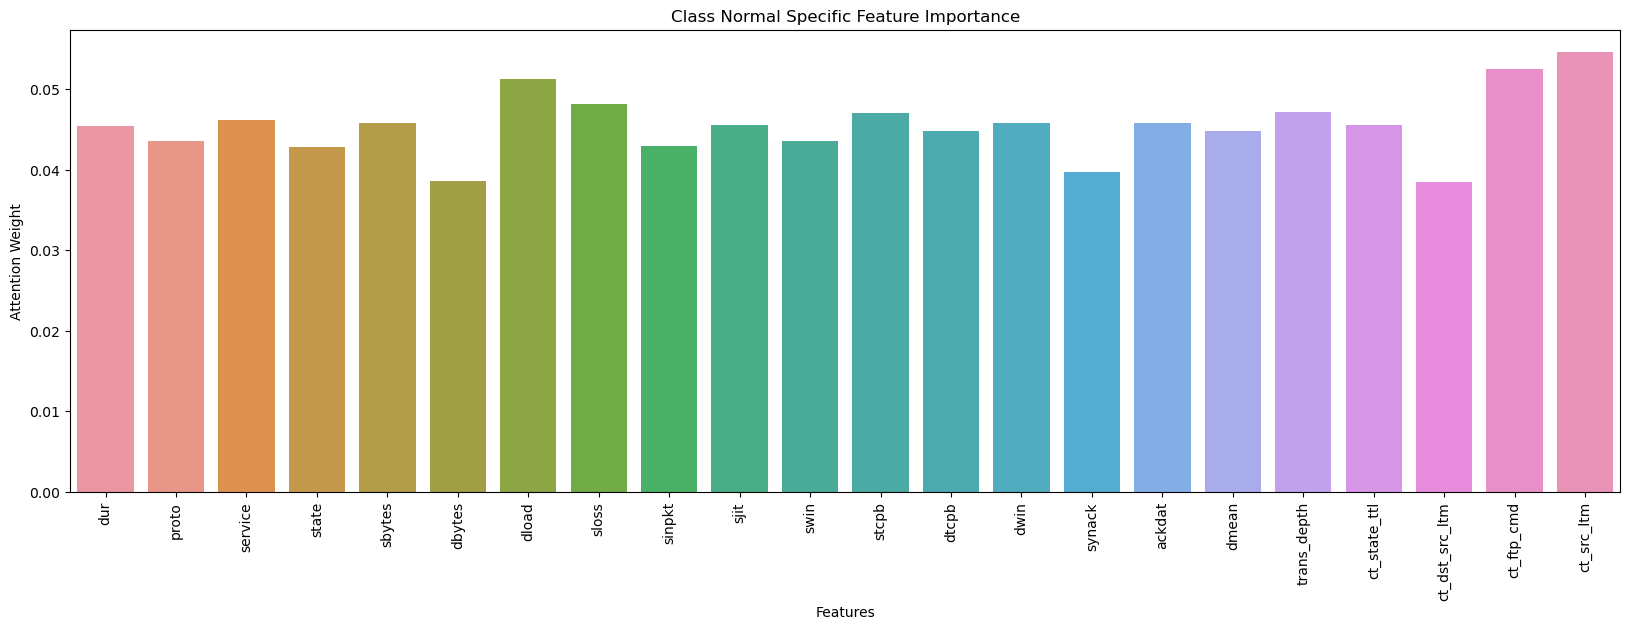

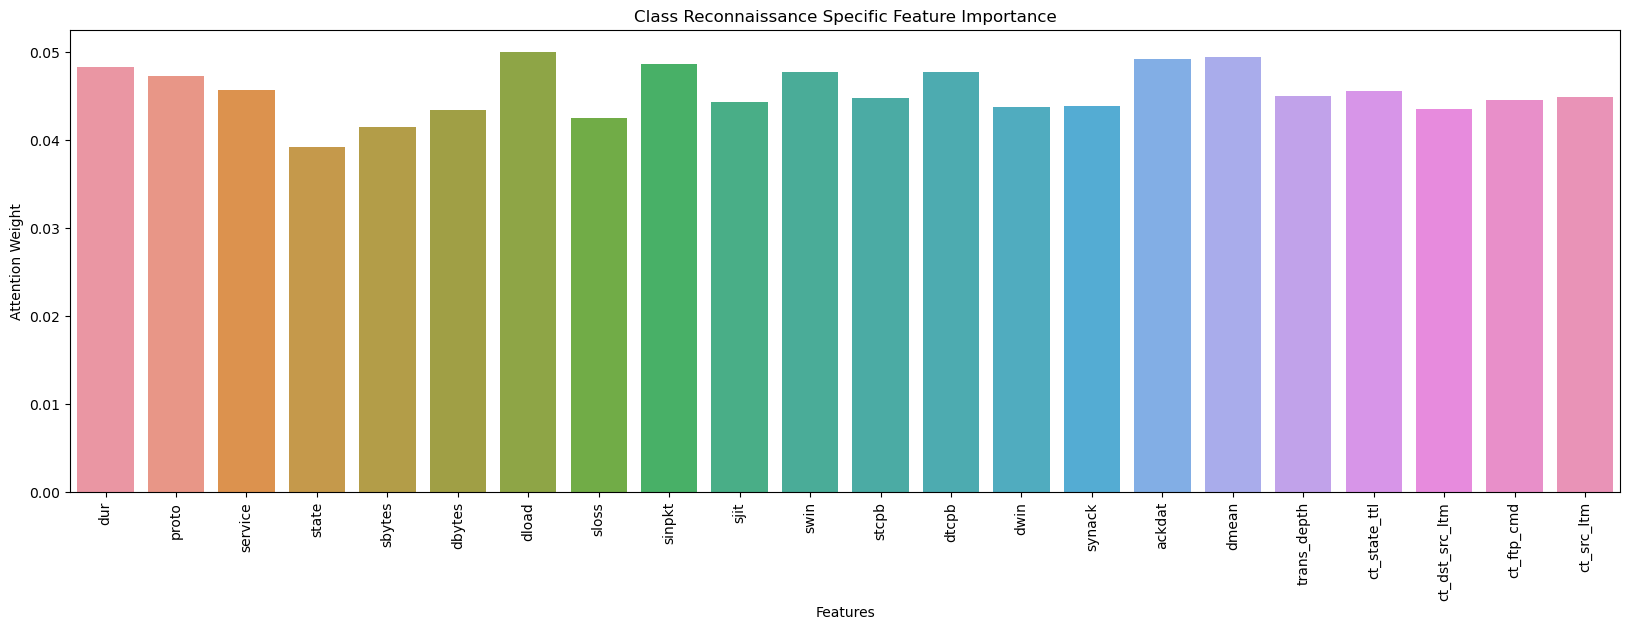

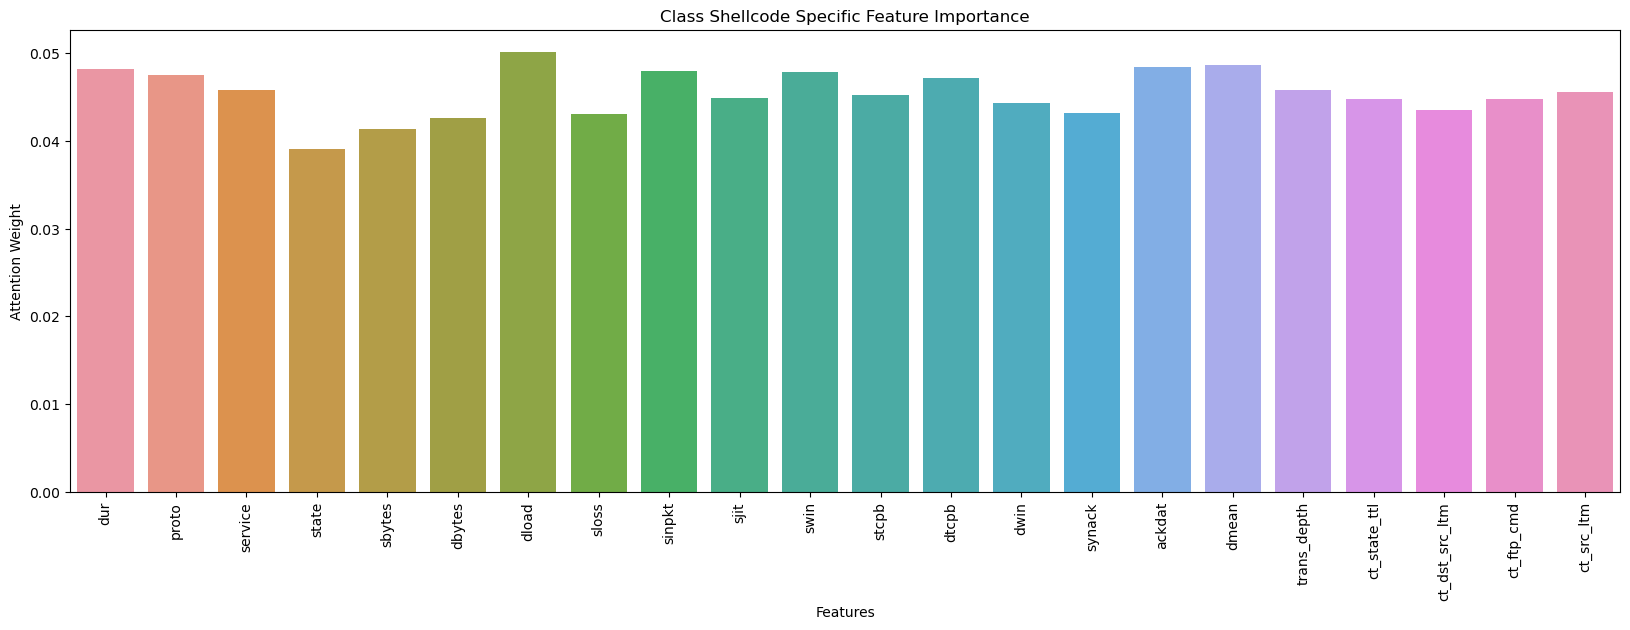

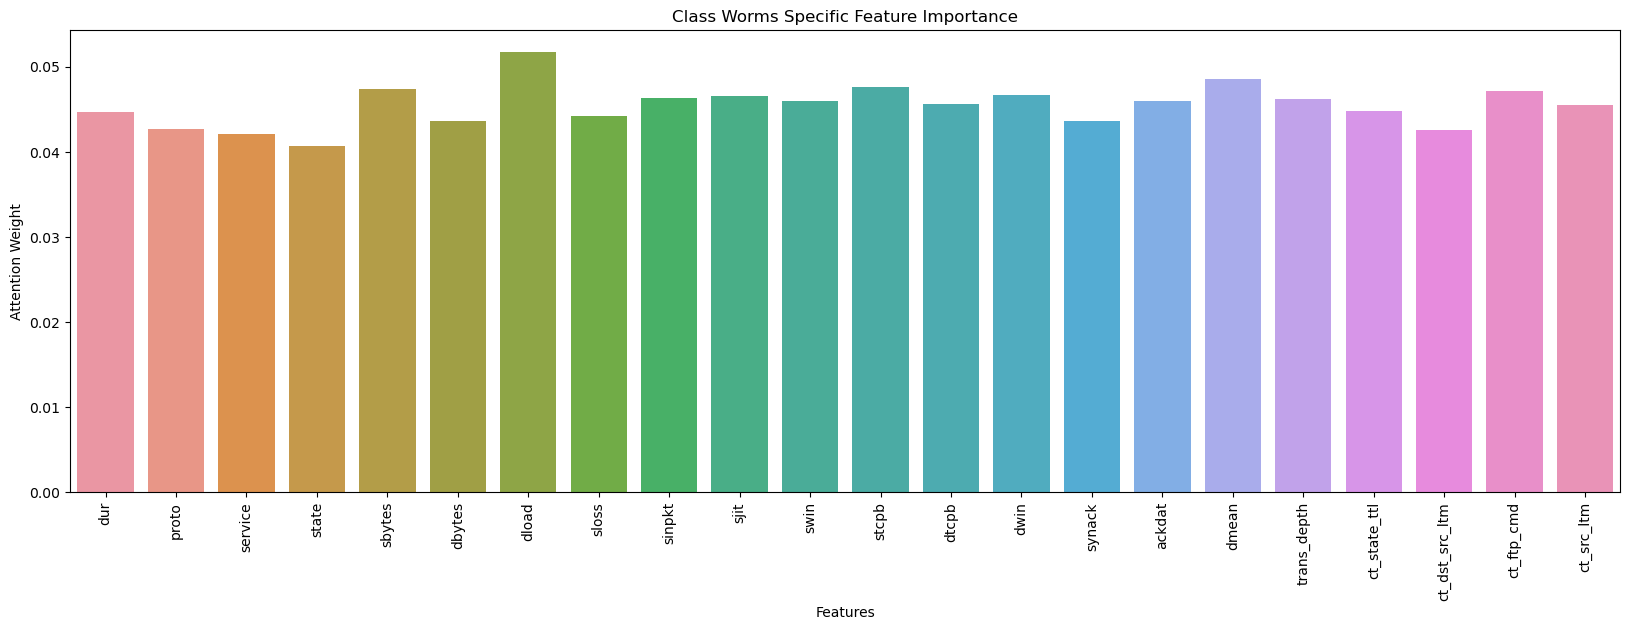

In [211]:
# Ensure you have the actual feature names
feature_names = df_selected.columns.tolist()

# Initialize an array to store class-specific attention weights
class_specific_weights = np.zeros((num_classes, len(feature_names)))

# Loop over each class and compute the average attention weights for instances of that class
for class_idx in range(num_classes):
    class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]
    if len(class_indices) > 0:
        class_specific_weights[class_idx] = np.mean(attention_weights_test[class_indices], axis=0)
    else:
        print(f"No samples found for class {class_idx}.")

# Plot the attention weights for each class and save the plots
for class_idx in range(num_classes):
    plt.figure(figsize=(20, 6))
    sns.barplot(
        x=feature_names,  # Use the actual feature names here
        y=class_specific_weights[class_idx]
    )
    plt.title(f'Class {label_encoder.classes_[class_idx]} Specific Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Attention Weight')
    plt.xticks(rotation=90)
    
    # Save the plot to a file
    filename = f'class_{label_encoder.classes_[class_idx]}_feature_importance.png'
    plt.savefig(filename, bbox_inches='tight')
    
    # Optionally, display the plot
    plt.show()

In [219]:
feature_names = df_selected.columns.tolist()

In [220]:
attention_df = pd.DataFrame({
    'Feature': feature_names,  # Use the actual feature names here
    'Attention Weight': avg_attention_weights
})

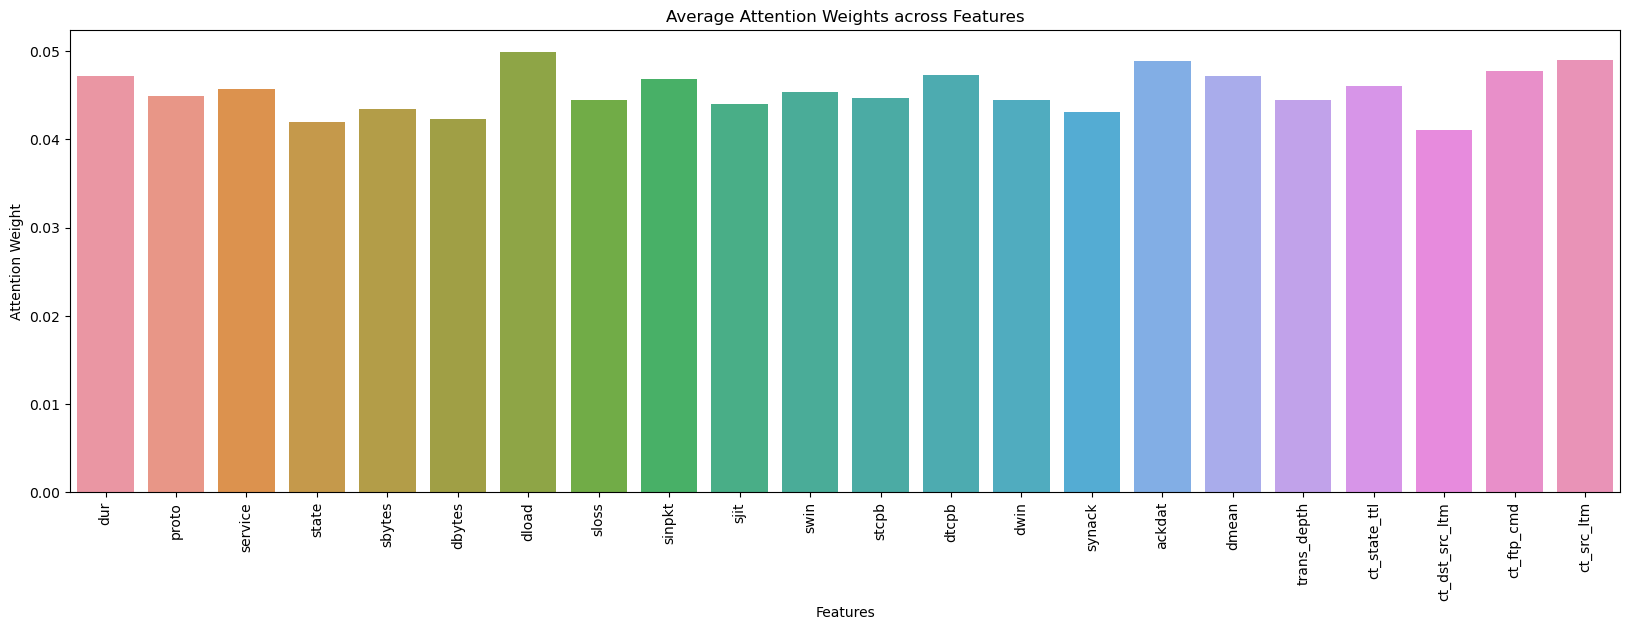

In [221]:
# Visualize attention weights for feature importance
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Average Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)

# Save the plot to a file
plt.savefig('attention_weights_feature_importance.png', bbox_inches='tight')

# Show the plot
plt.show()

In [223]:
# Average the attention weights across all samples
avg_attention_weights = np.mean(attention_weights_test, axis=0)
# Create a DataFrame for visualization with actual feature names
attention_df = pd.DataFrame({
    'Feature': feature_names,  # Use actual feature names here
    'Attention Weight': avg_attention_weights
})

# Display the DataFrame to check the results
print(attention_df)

           Feature  Attention Weight
0              dur          0.047234
1            proto          0.044930
2          service          0.045714
3            state          0.042024
4           sbytes          0.043414
5           dbytes          0.042296
6            dload          0.049915
7            sloss          0.044435
8           sinpkt          0.046828
9             sjit          0.044035
10            swin          0.045360
11           stcpb          0.044668
12           dtcpb          0.047275
13            dwin          0.044449
14          synack          0.043092
15          ackdat          0.048876
16           dmean          0.047163
17     trans_depth          0.044450
18    ct_state_ttl          0.046071
19  ct_dst_src_ltm          0.041083
20      ct_ftp_cmd          0.047700
21      ct_src_ltm          0.048985
